In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score
from resnet50_mlp_fusion import SupCEResNet_Fusion  
from train import train_model
from data_preprocessing import get_data_loaders
import torch.nn as nn
import torch.optim as optim
from train import train_model

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define model
model = SupCEResNet_Fusion(
    name='resnet50',
    num_classes=1,  # Regression or binary classification
    num_features=14,  # Number of biomarkers
    in_channels=3  # RGB images
).to(DEVICE)

# Define the criterion and optimizer
criterion = nn.MSELoss()  # Use MSELoss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loader, test_loader, val_loader = get_data_loaders()
# Train the model
train_losses, test_losses = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    epochs=25
)


Epoch 1/25 - Train Loss: 404.9020, Val Loss: 13.8375
Epoch 2/25 - Train Loss: 9.2083, Val Loss: 10.0866
Epoch 3/25 - Train Loss: 4.4545, Val Loss: 2.7990
Epoch 4/25 - Train Loss: 3.3937, Val Loss: 2.1414
Epoch 5/25 - Train Loss: 2.9323, Val Loss: 1.9691
Epoch 6/25 - Train Loss: 2.1718, Val Loss: 1.9270
Epoch 7/25 - Train Loss: 1.9023, Val Loss: 0.8456
Epoch 8/25 - Train Loss: 1.4815, Val Loss: 4.9423
Epoch 9/25 - Train Loss: 1.9161, Val Loss: 3.4224
Epoch 10/25 - Train Loss: 1.2617, Val Loss: 1.4337
Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.
Epoch 11/25 - Train Loss: 1.3563, Val Loss: 1.5840
Epoch 12/25 - Train Loss: 0.5177, Val Loss: 0.3896
Epoch 13/25 - Train Loss: 0.3416, Val Loss: 0.2891
Epoch 14/25 - Train Loss: 0.3070, Val Loss: 0.3538
Epoch 15/25 - Train Loss: 0.2437, Val Loss: 0.2533
Epoch 16/25 - Train Loss: 0.2341, Val Loss: 0.2045
Epoch 17/25 - Train Loss: 0.2270, Val Loss: 0.3491
Epoch 18/25 - Train Loss: 0.1922, Val Loss: 0.2200
Epoch 19/25 - Train Loss:

In [3]:
torch.save(model, "resnet50.pth")

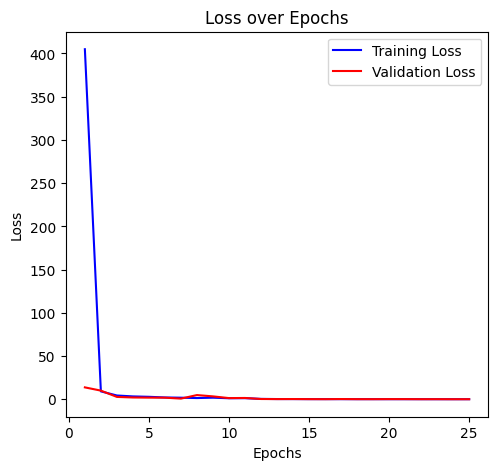

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_losses) + 1)

# Training loss + validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", color="blue")
plt.plot(epochs, test_losses, label="Test Loss", color="red")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()